<a href="https://colab.research.google.com/github/Mango1218/iccv/blob/master/net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LeNet

---

MNIST数据集

1.   50000个训练数据，10000个测试数据
2.   图像大小28*28
3.   10类

总结：
- 有两个卷积层、两个池化层、两个全连接层、一个输出层
- 先使用卷积层来学习图片空间信息
- 然后使用全连接层来转换到类别空间

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
class Reshape(torch.nn.Module):
  def forward(self, x):
    # view 大体上和 reshape 没啥区别
    return x.view(-1, 1, 28, 28)
net = torch.nn.Sequential(
    Reshape(), 
    # 输入通道是1，输出通道是6
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    # 分别是输入输出数目 由16*5*5降到120 
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [7]:
X = torch.rand(size=(1,1,28,28), dtype=torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [8]:
# LeNet在Fashion-MNIST数据集上的表现
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
# 对evaluate_accuracy函数进行轻微的修改
def evaluate_accuracy_gpu(net, data_iter, device=None): 
   # 使用GPU计算模型在数据集上的精度
    if isinstance(net, nn.Module):
       # 切换成训练状态 把模型调整到验证状态，梯度清零，不调整权重
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [10]:
# 为了使用GPU，需要一些改动
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 初始化权重  如果是全连接层或者是卷积层 init.xavier_uniform_
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights) #相当于一个循环，对net里面的每一个parameter都去执行一次init_weights这个函数
    print('training on', device)
    net.to(device)  # 把参数放到GPU内存上
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    # 对每一次数据进行迭代
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 输入输出放到GPU上
            X, y = X.to(device), y.to(device)
            # 进行前向操作
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 计算梯度
            l.backward()
            # 进行迭代 根据结果更新参数
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.456, train acc 0.829, test acc 0.776
37560.6 examples/sec on cuda:0


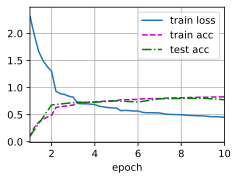

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.557, train acc 0.787, test acc 0.757
38237.8 examples/sec on cuda:0


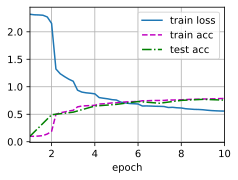

In [12]:
lr, num_epochs = 0.5, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

由上面可以看出，lr太小，收敛速度慢

输出通道很大程度可以认为是匹配了某一种特定的模式（每一个通道可能匹配了某一个局部的特征）\
通道数增加，可以理解为增加的是神经网络学习到的捕获到的信息特征(信息量是一定的，就看网络能够学到多少了)\
给更多的通道数，希望能够识别更多信息特征，但具体能够识别到什么样的模型是根据具体的网络


AlexNet

---

ImageNet(2010) \


1.   图片：自然物体的彩色图片
2.   大小：469*387
3.   样本数：1.2M
4.   类别数：1000

主要改进：


1.   丢弃法
2.   ReLU
3.   MaxPooling

图片 - 人工特征提取 - SVM \
图片 - 通过CNN学习特征 - softmax回归 \
AlexNet是更大更深的LeNet


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # 这里，我们使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

In [2]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [ ]:
# 这里数据集是28*28的，即Fashion- MNIST图像的分辨率低于ImageNet图像，于是将他们增加到224*224 （resize）
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)


loss 0.218, train acc 0.918, test acc 0.899
1453.4 examples/sec on cuda:0


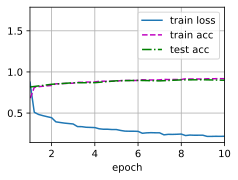

In [4]:
lr, num_epochs = 0.05, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

VGG

---

(AlexNet比LeNet更深更大来得到更好的精度，那么能否更进一步让精度更好？\
选项：1）更多的全连接层（太贵）
2）更多的卷积层
3）将卷积层组合成块) \

VGG块：1）3x3卷积（填充1）（n层 m通道）2）2x2池化层（步幅2）

VGG架构：1）多个VGG块后接全连接层
2）不同次数的重复块得到不同的架构VGG-16（16个卷积层，包括最后全连接层）、VGG-19 \
（VGG把AlexNet的卷积架构部分替换为n个VGG块）

1）VGG使用可重复使用的卷积块来构建深度卷积神经网络 \
2）不同的卷积块个数和超参数可以得到不同复杂度的变种







*   LeNet
  *   2卷积+2池化层
  *   2全连接层
*   AlexNet
  *   更大更深
  *   ReLU、Dropout、数据增强
*   VGG
  *   更大更深的AlexNet（重复的VGG块）










In [ ]:
# VGG块
import torch 
from torch import nn
from d2l import torch as d2l

In [ ]:
def vgg_block(num_convs, in_channels, out_channels):
  # 参数：num_convs需要多少个卷积层 输入和输出通道数
  layers = []
  for _ in range(num_convs):
    # 遍历每一层，进行卷积、relu
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
    in_channels = out_channels
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  # 最后把所有层传到nn.Sequential里面，构造一个VGG块 
  return nn.Sequential(*layers) # *layer解包 把列表layers里面的元素取出来

In [ ]:
# VGG网络
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2,512))
# 给定一个架构 包括5个块 每一块：（几层卷积，通道数多少）

def vgg(conv_arch):
  conv_blks = []
  in_channels = 1
  for (num_convs, out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
    in_channels = out_channels
  
  return nn.Sequential(
      *conv_blks, nn.Flatten(),
      # out_channels * 7 * 7是flatten后的数字，通道数*宽*高 
      # 原始图像224，进行5次减半后 即224进行5次除2 得到7，即宽高变为7*7
      nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(),
      nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(),
      nn.Dropout(0.5), nn.Linear(4096, 10)
      )
net = vgg(conv_arch)

In [ ]:
# 观察每个层输出的形状
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
  X = blk(X)
  print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

In [ ]:
# VGG-11比AlexNet计算量更大，因此构建了一个通道数较少的网络
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.244, train acc 0.910, test acc 0.895
706.9 examples/sec on cuda:0


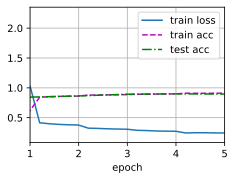

In [ ]:
lr, num_epochs, batch_size = 0.1, 5, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

NiN

---

NiN块：
*   一个卷积层后跟两个全连接层（1x1的卷积层）
  *   步幅为1，无填充，输出形状跟卷积层输出一样
  *   起到全连接层的作用

（1x1的卷积层等价于一个全连接层）

NiN架构：
*   无全连接层
*   交替使用NiN块和步幅为2的最大池化层
  *   逐步减少高宽和增加通道数
*   最后使用全局平均池化层得到输出（全局池化层：池化层的高宽等于输入的高宽，每一个通道作用全局池化后只有一个输出值）
  *   其输入通道数是类别数

总结：1）NiN块使用卷积层加两个1x1卷积层
（1x1卷积层对每个像素增加了非线性性）\
2）NiN使用全局平均池化层来替代VGG和AlexNet中的全连接层
（不容易过拟合，更少的参数个数）

（移除全连接层可减少过拟合，同时显著减少NiN的参数）


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# NiN块
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
      nn.ReLU(),
      # kernel_size=1,padding默认为0，strides默认为1  不改变通道数
      nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
  )

In [ ]:
# NiN模型
net = nn.Sequential(
    # 因为用的是灰度图，所以这里输入通道是1
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2), 
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 全局平均池化 这里(1, 1)表示高宽都会变成1  因为全局平均池化后，每一个通道输出一个值，即（1，1）
    nn.Flatten()  # 得到4维数据，这个flatten()消掉最后两个维度，最后两个维度是宽高（1，1），保留前两个维度 批量大小数和通道数 这里的通道数就是10个类别数
)

In [ ]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (5): MaxPool2d(kernel_size=3, stri

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.334, train acc 0.876, test acc 0.888
1052.7 examples/sec on cuda:0


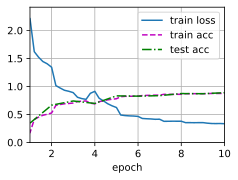

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

GoogLeNet

---

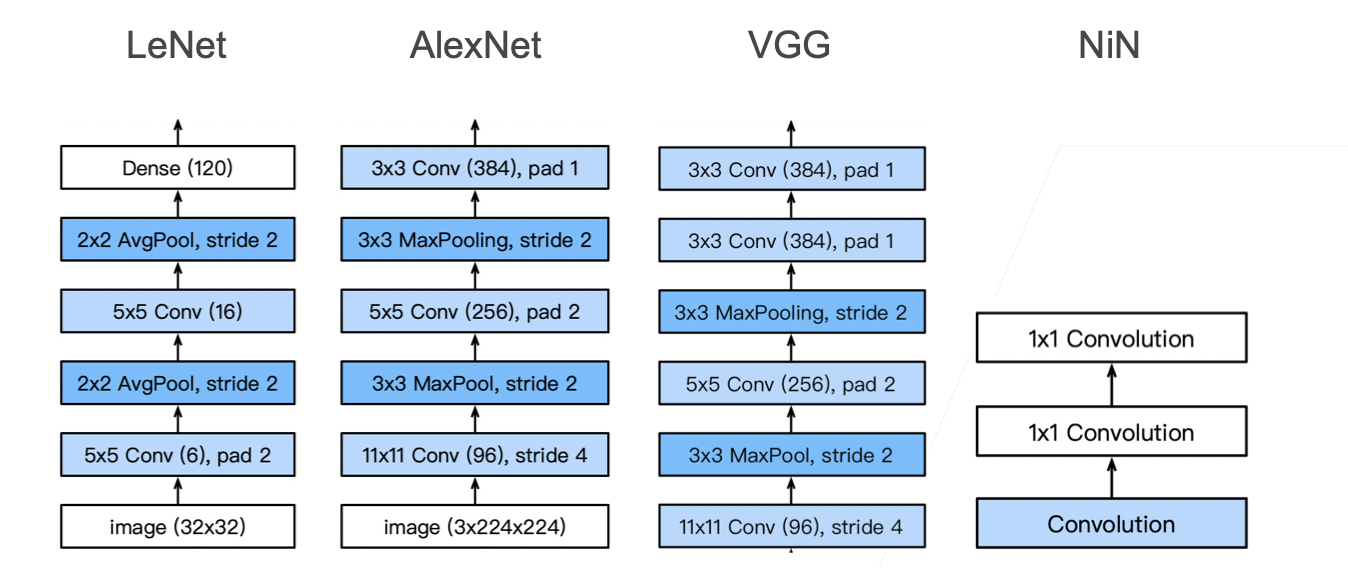

Inception块（不改变高宽，只改变通道数）

4个路径从不同层面抽取信息，然后在输出通道维合并
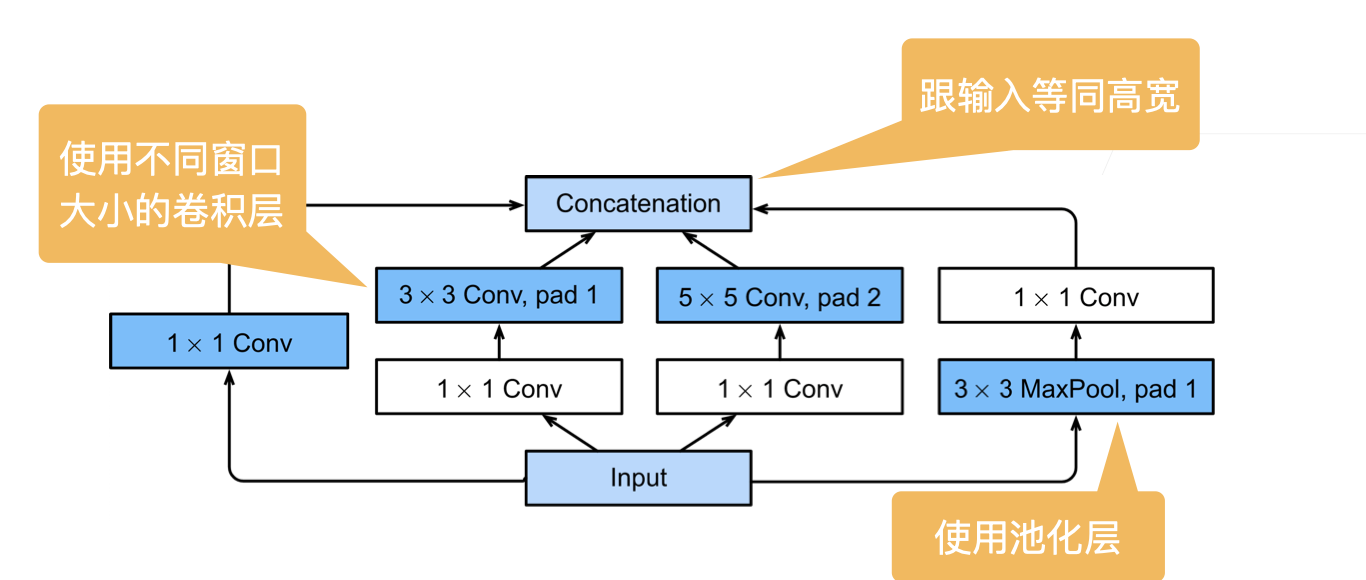

（对于输入图像，分别用不同大小的卷积核进行卷积，方式same，保证输入输出大小一样。不同的卷积，卷积核个数可以不一样，即卷积之后得到的宽高是一样的，通道数可以是不一样的。这个网络的特点是不用只挑选一个卷积核的大小或者是pooling，可以所有的都做，然后把所有的输出结果都连接起来，然后让神经网络去学习它想用的的参数以及卷积核大小）

跟单3x3或5x5卷积层比，Inception块有更少的参数个数和计算复杂度
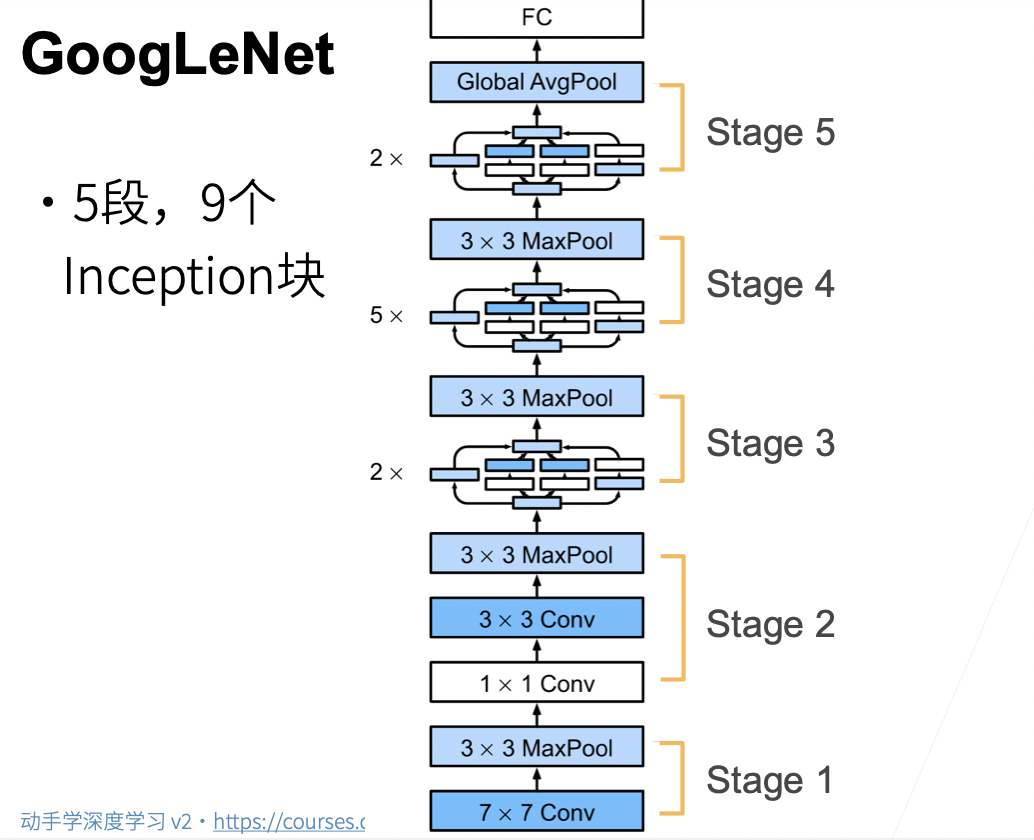

1）Inception块用4条有不同超参数的卷积层和池化层的路来抽取不同的信息
（它的一个主要优点是模型参数小，计算复杂度低）

2）GooleNet使用了9个Inception块，是第一个达到上百层的网络

GooleNet使用了很多1x1卷积以及Global AvgPool（借鉴NiN网络）